Quantile 0.25
2014 comp: 46.5	2014 life: 209.0
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>46']
	Current list_where_clauses: ['`viewCount`>46', "`content`='paper_reference'"]
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>46 AND `content`='paper_reference');
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 67 videos
[+]Processing 2 of 

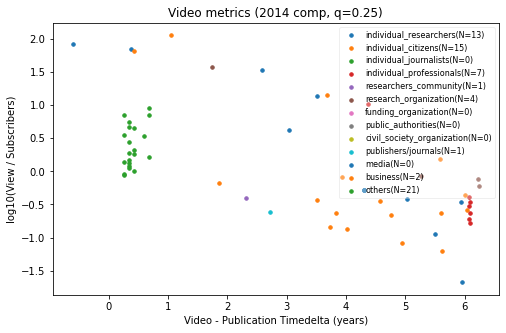

In [13]:
# Reference를 스타일별로 플롯
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

db_handler = DBHandler()
_list_fields = [
"idx",
"idx_paper",
"content",
"video_visual",
"publishedAt",
"duration",
"channelId",
"viewCount",
"likeCount",
"dislikeCount",
"commentCount",
"favoriteCount",
"liveStreaming"
]
_list_videos = list()

# Calc quantile
_q = .25
_q_2014_comp = pd.read_csv("scopus/scopus_videos_2014_comp.csv", header=0)["viewCount"].quantile(_q)
_q_2014_life = pd.read_csv("scopus/scopus_videos_2014_life.csv", header=0)["viewCount"].quantile(_q)
print("Quantile %.2f\n2014 comp: %.1f\t2014 life: %.1f" % (_q, _q_2014_comp, _q_2014_life))

# 2014 comp
db_handler.sql_handler.select(
"scopus_videos_2014_comp",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_comp, ">").where("content", "paper_reference")
_list_videos += db_handler.execute().fetchall()

# 2014 life
# db_handler.sql_handler.select(
# "scopus_videos_2014_life",
# _list_fields
# # ).where("viewCount", 1000, ">").where("content", "paper_reference")
# ).where("viewCount", _q_2014_life, ">") # 모든 비디오를 선택
# _list_videos += db_handler.execute().fetchall()

_list_dict_videos = list(
map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

# Channels : Get subscriber count
_list_columns_channels = ["idx", "channelId", "subscriberCount", "user_type"]
db_handler.sql_handler.select(
"channels",
_list_columns_channels
).where("subscriberCount", None, "<>")  # Filter NULL subscriberCount
_list_channels = db_handler.execute().fetchall()
# {channelId : tuple(...), ...}
_dict_channels = dict(
zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

# Hashmap
## User types
_list_user_types = [
    "individual_researchers",
    "individual_citizens",
    "individual_journalists",
    "individual_professionals",
    "researchers_community",
    "research_organization",
    "funding_organization",
    "public_authorities",
    "civil_society_organization",
    "publishers/journals",
    "media",
    "business",
    "others",
]

dict_content_key = dict()
dict_x = dict()
dict_y = dict()
for _user_type in _list_user_types:
    dict_content_key[_user_type] = _user_type
    dict_x[_user_type] = list()
    dict_y[_user_type] = list()

df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
df = pd.concat([df1, df2])

for _i, _dict_row in enumerate(_list_dict_videos):
    print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
    # Calc age
    _date_video = _dict_row["publishedAt"].date()
    _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
    if len(_scopus_row) > 1:
        _scopus_row = _scopus_row.iloc[0]
    _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
    _age = (_date_video - _date_paper).days/365
    _dict_row["age"] = _age

    # Age - Scaled View
    # Calc view/subscriber
#     _dict_row["scaled_view"] = _dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["viewCount"]
    try:
        _dict_row["scaled_view"] = np.log10(_dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row["viewCount"])
        dict_y[dict_content_key[_dict_channels[_dict_row["channelId"]][3]]].append(_dict_row["scaled_view"])
    except KeyError:  # Channel must have been filtered due to null subscriberCount
        continue
    

    # Age - Scaled Like
    # Calc like/subscriber
    # _dict_row["scaled_like"] = _dict_row["likeCount"] / _dict_channels[_dict_row["channelId"]
    #                                                                    ][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["scaled_like"])

    # Age - View
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["viewCount"])
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(np.log10(_dict_row["viewCount"]))

    # Age - Like
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["likeCount"])

    # Boxplot: like/dislike
    # if _dict_row["likeCount"] in (None, 0) or _dict_row["dislikeCount"] == None:
    #     continue
    # _dict_row["r_like_dislike"] = _dict_row["likeCount"] / _dict_row["dislikeCount"] if _dict_row["dislikeCount"] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(_dict_row["r_like_dislike"])

    # Add x
    dict_x[dict_content_key[_dict_channels[_dict_row["channelId"]][3]]].append(_dict_row["age"])

# Scatter
plt.figure(figsize=(8, 5))

_tup_plts = tuple(map(lambda _user_type: plt.scatter(x=dict_x[_user_type], y=dict_y[_user_type], s=12, marker="o"), _list_user_types))
_tup_legends = tuple(map(lambda _user_type: "%s(N=%d)" % (_user_type, len(dict_y[_user_type])), _list_user_types))

# cre = plt.scatter(x=dict_x["creative"],
#             y=dict_y["creative"], s=12, marker="o", color="blue")
# pre = plt.scatter(x=dict_x["presentation"],
#             y=dict_y["presentation"], s=12, marker="x", color="black")
# raw = plt.scatter(x=dict_x["raw"],
#             y=dict_y["raw"], s=12, marker="o", color="green")
# fix = plt.scatter(x=dict_x["fixed"],
#             y=dict_y["fixed"], s=12, marker="o", color="red")

plt.legend(_tup_plts,
    _tup_legends,
    scatterpoints=1,
    loc='upper right',
    fontsize=8,
    framealpha=0.3
)

# plt.legend((cre, pre, raw, fix),
#     (
#         "creative(N=%d)" % len(dict_y["creative"]),
#         "presentation(N=%d)" % len(dict_y["presentation"]),
#         "raw(N=%d)" % len(dict_y["raw"]),
#         "fixed(N=%d)" % len(dict_y["fixed"]),
#     ),
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8,
#     framealpha=0.3)

# xs = dict_x["paper_explanation"] + dict_x["paper_reference"] + \
#     dict_x["paper_supplementary"] + dict_x["paper_assessment"]
# ys = dict_y["paper_explanation"] + dict_y["paper_reference"] + \
#     dict_y["paper_supplementary"] + dict_y["paper_assessment"]
# cs = ["blue"] * len(dict_y["paper_explanation"]) + ["black"] * len(dict_y["paper_reference"]) + \
#     ["green"] * len(dict_y["paper_supplementary"]) + \
#     ["red"] * len(dict_y["paper_assessment"])
# plt.scatter(x=xs, y=ys, s=10, c=cs)

plt.title("Video metrics (2014 comp, q=%.2f)" % _q)
plt.xlabel("Video - Publication Timedelta (years)")
plt.ylabel("log10(View / Subscribers)")
# plt.yscale("log")
# plt.ylim(1, 100000)
plt.show()

Quantile 0.25
2014 comp: 46.5	2014 life: 209.0
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>209']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life` WHERE (`viewCount`>209);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 84 videos
[+]Processing 2 of 84 videos
[+]Processing 3 of 84 videos
[+]Processing 4 of 84 videos
[+]Processing 5 of 84 videos
[+]Processin

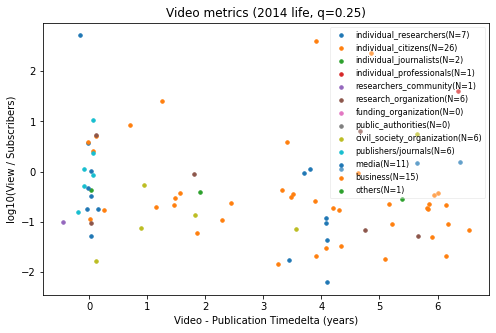

In [15]:
# Reference를 스타일별로 플롯
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

db_handler = DBHandler()
_list_fields = [
"idx",
"idx_paper",
"content",
"video_visual",
"publishedAt",
"duration",
"channelId",
"viewCount",
"likeCount",
"dislikeCount",
"commentCount",
"favoriteCount",
"liveStreaming"
]
_list_videos = list()

# Calc quantile
_q = .25
_q_2014_comp = pd.read_csv("scopus/scopus_videos_2014_comp.csv", header=0)["viewCount"].quantile(_q)
_q_2014_life = pd.read_csv("scopus/scopus_videos_2014_life.csv", header=0)["viewCount"].quantile(_q)
print("Quantile %.2f\n2014 comp: %.1f\t2014 life: %.1f" % (_q, _q_2014_comp, _q_2014_life))

# 2014 comp
# db_handler.sql_handler.select(
# "scopus_videos_2014_comp",
# _list_fields
# # ).where("viewCount", 1000, ">").where("content", "paper_reference")
# ).where("viewCount", _q_2014_comp, ">").where("content", "paper_reference")
# _list_videos += db_handler.execute().fetchall()

# 2014 life
db_handler.sql_handler.select(
"scopus_videos_2014_life",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_life, ">") # 모든 비디오를 선택
_list_videos += db_handler.execute().fetchall()

_list_dict_videos = list(
map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

# Channels : Get subscriber count
_list_columns_channels = ["idx", "channelId", "subscriberCount", "user_type"]
db_handler.sql_handler.select(
"channels",
_list_columns_channels
).where("subscriberCount", None, "<>")  # Filter NULL subscriberCount
_list_channels = db_handler.execute().fetchall()
# {channelId : tuple(...), ...}
_dict_channels = dict(
zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

# Hashmap
## User types
_list_user_types = [
    "individual_researchers",
    "individual_citizens",
    "individual_journalists",
    "individual_professionals",
    "researchers_community",
    "research_organization",
    "funding_organization",
    "public_authorities",
    "civil_society_organization",
    "publishers/journals",
    "media",
    "business",
    "others",
]

dict_content_key = dict()
dict_x = dict()
dict_y = dict()
for _user_type in _list_user_types:
    dict_content_key[_user_type] = _user_type
    dict_x[_user_type] = list()
    dict_y[_user_type] = list()

df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
df = pd.concat([df1, df2])

for _i, _dict_row in enumerate(_list_dict_videos):
    print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
    # Calc age
    _date_video = _dict_row["publishedAt"].date()
    _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
    if len(_scopus_row) > 1:
        _scopus_row = _scopus_row.iloc[0]
    _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
    _age = (_date_video - _date_paper).days/365
    _dict_row["age"] = _age

    # Age - Scaled View
    # Calc view/subscriber
#     _dict_row["scaled_view"] = _dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["viewCount"]
    try:
        _dict_row["scaled_view"] = np.log10(_dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row["viewCount"])
        dict_y[dict_content_key[_dict_channels[_dict_row["channelId"]][3]]].append(_dict_row["scaled_view"])
    except KeyError:  # Channel must have been filtered due to null subscriberCount
        continue

    # Age - Scaled Like
    # Calc like/subscriber
    # _dict_row["scaled_like"] = _dict_row["likeCount"] / _dict_channels[_dict_row["channelId"]
    #                                                                    ][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["scaled_like"])

    # Age - View
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["viewCount"])
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(np.log10(_dict_row["viewCount"]))

    # Age - Like
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["likeCount"])

    # Boxplot: like/dislike
    # if _dict_row["likeCount"] in (None, 0) or _dict_row["dislikeCount"] == None:
    #     continue
    # _dict_row["r_like_dislike"] = _dict_row["likeCount"] / _dict_row["dislikeCount"] if _dict_row["dislikeCount"] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(_dict_row["r_like_dislike"])

    # Add x
    dict_x[dict_content_key[_dict_channels[_dict_row["channelId"]][3]]].append(_dict_row["age"])

# Scatter
plt.figure(figsize=(8, 5))

_tup_plts = tuple(map(lambda _user_type: plt.scatter(x=dict_x[_user_type], y=dict_y[_user_type], s=12, marker="o"), _list_user_types))
_tup_legends = tuple(map(lambda _user_type: "%s(N=%d)" % (_user_type, len(dict_y[_user_type])), _list_user_types))

# cre = plt.scatter(x=dict_x["creative"],
#             y=dict_y["creative"], s=12, marker="o", color="blue")
# pre = plt.scatter(x=dict_x["presentation"],
#             y=dict_y["presentation"], s=12, marker="x", color="black")
# raw = plt.scatter(x=dict_x["raw"],
#             y=dict_y["raw"], s=12, marker="o", color="green")
# fix = plt.scatter(x=dict_x["fixed"],
#             y=dict_y["fixed"], s=12, marker="o", color="red")

plt.legend(_tup_plts,
    _tup_legends,
    scatterpoints=1,
    loc='upper right',
    fontsize=8,
    framealpha=0.3
)

# plt.legend((cre, pre, raw, fix),
#     (
#         "creative(N=%d)" % len(dict_y["creative"]),
#         "presentation(N=%d)" % len(dict_y["presentation"]),
#         "raw(N=%d)" % len(dict_y["raw"]),
#         "fixed(N=%d)" % len(dict_y["fixed"]),
#     ),
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8,
#     framealpha=0.3)

# xs = dict_x["paper_explanation"] + dict_x["paper_reference"] + \
#     dict_x["paper_supplementary"] + dict_x["paper_assessment"]
# ys = dict_y["paper_explanation"] + dict_y["paper_reference"] + \
#     dict_y["paper_supplementary"] + dict_y["paper_assessment"]
# cs = ["blue"] * len(dict_y["paper_explanation"]) + ["black"] * len(dict_y["paper_reference"]) + \
#     ["green"] * len(dict_y["paper_supplementary"]) + \
#     ["red"] * len(dict_y["paper_assessment"])
# plt.scatter(x=xs, y=ys, s=10, c=cs)

plt.title("Video metrics (2014 life, q=%.2f)" % _q)
plt.xlabel("Video - Publication Timedelta (years)")
plt.ylabel("log10(View / Subscribers)")
# plt.yscale("log")
# plt.ylim(1, 100000)
plt.show()

Quantile 0.25
2014 comp: 46.5	2014 life: 209.0
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>46']
	Current list_where_clauses: ['`viewCount`>46', "`content`='paper_reference'"]
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>46 AND `content`='paper_reference');
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>209']
	sql: SELECT `idx`, `idx_paper`, `conte

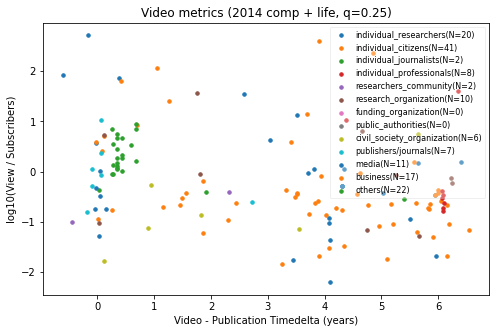

In [16]:
# Reference를 스타일별로 플롯
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from db_handler import DBHandler
from datetime import date
%matplotlib inline

db_handler = DBHandler()
_list_fields = [
"idx",
"idx_paper",
"content",
"video_visual",
"publishedAt",
"duration",
"channelId",
"viewCount",
"likeCount",
"dislikeCount",
"commentCount",
"favoriteCount",
"liveStreaming"
]
_list_videos = list()

# Calc quantile
_q = .25
_q_2014_comp = pd.read_csv("scopus/scopus_videos_2014_comp.csv", header=0)["viewCount"].quantile(_q)
_q_2014_life = pd.read_csv("scopus/scopus_videos_2014_life.csv", header=0)["viewCount"].quantile(_q)
print("Quantile %.2f\n2014 comp: %.1f\t2014 life: %.1f" % (_q, _q_2014_comp, _q_2014_life))

# 2014 comp
db_handler.sql_handler.select(
"scopus_videos_2014_comp",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_comp, ">").where("content", "paper_reference")
_list_videos += db_handler.execute().fetchall()

# 2014 life
db_handler.sql_handler.select(
"scopus_videos_2014_life",
_list_fields
# ).where("viewCount", 1000, ">").where("content", "paper_reference")
).where("viewCount", _q_2014_life, ">") # 모든 비디오를 선택
_list_videos += db_handler.execute().fetchall()

_list_dict_videos = list(
map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

# Channels : Get subscriber count
_list_columns_channels = ["idx", "channelId", "subscriberCount", "user_type"]
db_handler.sql_handler.select(
"channels",
_list_columns_channels
).where("subscriberCount", None, "<>")  # Filter NULL subscriberCount
_list_channels = db_handler.execute().fetchall()
# {channelId : tuple(...), ...}
_dict_channels = dict(
zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

# Hashmap
## User types
_list_user_types = [
    "individual_researchers",
    "individual_citizens",
    "individual_journalists",
    "individual_professionals",
    "researchers_community",
    "research_organization",
    "funding_organization",
    "public_authorities",
    "civil_society_organization",
    "publishers/journals",
    "media",
    "business",
    "others",
]

dict_content_key = dict()
dict_x = dict()
dict_y = dict()
for _user_type in _list_user_types:
    dict_content_key[_user_type] = _user_type
    dict_x[_user_type] = list()
    dict_y[_user_type] = list()

df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
df = pd.concat([df1, df2])

for _i, _dict_row in enumerate(_list_dict_videos):
    print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
    # Calc age
    _date_video = _dict_row["publishedAt"].date()
    _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
    if len(_scopus_row) > 1:
        _scopus_row = _scopus_row.iloc[0]
    _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
    _age = (_date_video - _date_paper).days/365
    _dict_row["age"] = _age

    # Age - Scaled View
    # Calc view/subscriber
#     _dict_row["scaled_view"] = _dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["viewCount"]
    try:
        _dict_row["scaled_view"] = np.log10(_dict_row["viewCount"] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row["viewCount"])
        dict_y[dict_content_key[_dict_channels[_dict_row["channelId"]][3]]].append(_dict_row["scaled_view"])
    except KeyError:  # Channel must have been filtered due to null subscriberCount
        continue

    # Age - Scaled Like
    # Calc like/subscriber
    # _dict_row["scaled_like"] = _dict_row["likeCount"] / _dict_channels[_dict_row["channelId"]
    #                                                                    ][2] if _dict_channels[_dict_row["channelId"]][2] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["scaled_like"])

    # Age - View
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(_dict_row["viewCount"])
#     dict_y[dict_content_key[_dict_row["video_visual"]]].append(np.log10(_dict_row["viewCount"]))

    # Age - Like
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(
    #     _dict_row["likeCount"])

    # Boxplot: like/dislike
    # if _dict_row["likeCount"] in (None, 0) or _dict_row["dislikeCount"] == None:
    #     continue
    # _dict_row["r_like_dislike"] = _dict_row["likeCount"] / _dict_row["dislikeCount"] if _dict_row["dislikeCount"] != 0 else _dict_row["likeCount"]
    # dict_y[dict_content_key[_dict_row["video_visual"]]]].append(_dict_row["r_like_dislike"])

    # Add x
    dict_x[dict_content_key[_dict_channels[_dict_row["channelId"]][3]]].append(_dict_row["age"])

# Scatter
plt.figure(figsize=(8, 5))

_tup_plts = tuple(map(lambda _user_type: plt.scatter(x=dict_x[_user_type], y=dict_y[_user_type], s=12, marker="o"), _list_user_types))
_tup_legends = tuple(map(lambda _user_type: "%s(N=%d)" % (_user_type, len(dict_y[_user_type])), _list_user_types))

# cre = plt.scatter(x=dict_x["creative"],
#             y=dict_y["creative"], s=12, marker="o", color="blue")
# pre = plt.scatter(x=dict_x["presentation"],
#             y=dict_y["presentation"], s=12, marker="x", color="black")
# raw = plt.scatter(x=dict_x["raw"],
#             y=dict_y["raw"], s=12, marker="o", color="green")
# fix = plt.scatter(x=dict_x["fixed"],
#             y=dict_y["fixed"], s=12, marker="o", color="red")

plt.legend(_tup_plts,
    _tup_legends,
    scatterpoints=1,
    loc='upper right',
    fontsize=8,
    framealpha=0.3
)

# plt.legend((cre, pre, raw, fix),
#     (
#         "creative(N=%d)" % len(dict_y["creative"]),
#         "presentation(N=%d)" % len(dict_y["presentation"]),
#         "raw(N=%d)" % len(dict_y["raw"]),
#         "fixed(N=%d)" % len(dict_y["fixed"]),
#     ),
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8,
#     framealpha=0.3)

# xs = dict_x["paper_explanation"] + dict_x["paper_reference"] + \
#     dict_x["paper_supplementary"] + dict_x["paper_assessment"]
# ys = dict_y["paper_explanation"] + dict_y["paper_reference"] + \
#     dict_y["paper_supplementary"] + dict_y["paper_assessment"]
# cs = ["blue"] * len(dict_y["paper_explanation"]) + ["black"] * len(dict_y["paper_reference"]) + \
#     ["green"] * len(dict_y["paper_supplementary"]) + \
#     ["red"] * len(dict_y["paper_assessment"])
# plt.scatter(x=xs, y=ys, s=10, c=cs)

plt.title("Video metrics (2014 comp + life, q=%.2f)" % _q)
plt.xlabel("Video - Publication Timedelta (years)")
plt.ylabel("log10(View / Subscribers)")
# plt.yscale("log")
# plt.ylim(1, 100000)
plt.show()

In [9]:
def plot_timedelta_metrics(targets, metric="viewCount", q=0.25, where_videos=None, scale_by_sub=True, label_by="content", regression=True):
    # Reference를 스타일별로 플롯
    import numpy as np, pandas as pd
    import matplotlib.pyplot as plt
    from db_handler import DBHandler
    from datetime import date

    db_handler = DBHandler()
    _list_fields = [
    "idx",
    "idx_paper",
    "content",
    "video_visual",
    "publishedAt",
    "duration",
    "channelId",
    "viewCount",
    "likeCount",
    "dislikeCount",
    "commentCount",
    "favoriteCount",
    "liveStreaming"
    ]
    _list_videos = list()

    def fetch_videos(target, q_target, where_videos):
#         db_handler.sql_handler.select(
#             "scopus_videos_%s" % target,
#             _list_fields
#         ).where("viewCount", q_target, ">")
        
    
        _list_wheres_main = list()

        if where_videos != None:
            if type(where_videos) == list:
                for _where in where_videos:
                    if type(_where) == type(None):
                        continue
                    if _where[0] == "user_type":
                        _db_handler_secondary = DBHandler()
                        _db_handler_secondary.sql_handler.select("channels", "channelId").where("user_type", _where[1])
                        _list_channelIds_temp = list(map(lambda _row: _row[0], _db_handler_secondary.execute().fetchall()))
                        _where = ("channelId", _list_channelIds_temp, "in")
#                         _where = ("channelId", "SELECT `channelId` FROM channels WHERE `user_type`='%s'" % _where[1], "in")
                        print("\tCurrent where:", _where)
                        _list_wheres_main.append(_where)
#                         db_handler.sql_handler.where(*_where)
            else:
                _list_wheres_main.append(where_videos)
#                 db_handler.sql_handler.where(*where_videos)
        
        for _where in _list_wheres_main:
            db_handler.sql_handler.where(*_where)
        db_handler.sql_handler.select(
            "scopus_videos_%s" % target,
            _list_fields
        ).where("viewCount", q_target, ">")
        return db_handler.execute().fetchall()

    def calc_q_target(target, metric, q):
        _q_target = pd.read_csv("scopus/scopus_videos_%s.csv" % target, header=0)[metric].quantile(q)
        print("Quantile %.2f\n%s: %.1f\t" % (q, target, _q_target))
        return _q_target
    
    def get_list_videos(targets, metric, q, where_videos=None):
        _list_videos = list()
        if type(targets) in (tuple, list):
            for _target in targets:
                _q_target = calc_q_target(_target, metric, q)
                _list_videos += fetch_videos(_target, _q_target, where_videos)
        else:
            _q_target = calc_q_target(targets, metric, q)
            _list_videos += fetch_videos(targets, _q_target, where_videos)
        
        return _list_videos
    
    _list_videos = get_list_videos(targets, metric, q, where_videos)

    _list_dict_videos = list(
    map(lambda _row: dict(zip(_list_fields, _row)), _list_videos))

    # Channels : Get subscriber count
    _list_columns_channels = ["idx", "channelId", "subscriberCount", "user_type"]
    db_handler.sql_handler.select("channels", _list_columns_channels)
    if scale_by_sub:
        db_handler.sql_handler.where("subscriberCount", None, "<>")  # Filter off NULL subscriberCount
    _list_channels = db_handler.execute().fetchall()
    # {channelId : tuple(...), ...}
    _dict_channels = dict(
    zip(list(map(lambda _row: _row[1], _list_channels)), _list_channels))

    if label_by == "video_visual":
        _list_labels = [
            "creative",
            "presentation",
            "raw",
            "fixed"
        ]

    elif label_by == "user_type":
        _list_labels = [
            "individual_researchers",
            "individual_citizens",
            "individual_journalists",
            "individual_professionals",
            "researchers_community",
            "research_organization",
            "funding_organization",
            "public_authorities",
            "civil_society_organization",
            "publishers/journals",
            "media",
            "business",
            "others",
        ]

    elif label_by == "content":
        _list_labels = [
            "paper_explanation",
            "paper_linked_supplementary",
            "paper_supplementary",
            "paper_application",
            "paper_assessment",
            "paper_reference",
            "news",
        ]

    # Hashmap
    dict_content_key = dict()
    dict_x = dict()
    dict_y = dict()
    for _label in _list_labels:
        dict_content_key[_label] = _label
        dict_x[_label] = list()
        dict_y[_label] = list()

    df1 = pd.read_csv("scopus/scopus_math+comp_top5perc_1401-1406.csv", header=0)
    df2 = pd.read_csv("scopus/scopus_life+earch_top60_1401-1406.csv", header=0)
    df3 = pd.read_csv("scopus/scopus_math+comp_top5perc_1901-1906.csv", header=0)
    df4 = pd.read_csv("scopus/scopus_life+earch_top60_1901-1906.csv", header=0)
    df = pd.concat([df1, df2, df3, df4])
    
    _list_colors =  ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    _num_dots = 0
    for _i, _dict_row in enumerate(_list_dict_videos):
        print("[+]Processing %d of %d videos" % (_i+1, len(_list_dict_videos)))
        # Calc age
        _date_video = _dict_row["publishedAt"].date()
        _scopus_row = df[df["DOI"] == _dict_row["idx_paper"]]
        if len(_scopus_row) > 1:
            _scopus_row = _scopus_row.iloc[0]
        _date_paper = date(_scopus_row["Year"], _scopus_row["Month"], 1)
        _age = (_date_video - _date_paper).days/365
        _dict_row["age"] = _age

        # Add label
        if label_by == "video_visual":
            _dict_row["label"] = _dict_row["video_visual"]
        elif label_by == "content":
            _dict_row["label"] = _dict_row["content"]
        elif label_by == "user_type":
            try:
                _dict_row["label"] = _dict_channels[_dict_row["channelId"]][3]
            except KeyError:
                continue
#         print("\tLabel added: %s" % _dict_row["label"])

        if scale_by_sub:
            try:
                _dict_row["y_value"] = np.log10(_dict_row[metric] / _dict_channels[_dict_row["channelId"]][2]) if _dict_channels[_dict_row["channelId"]][2] != 0 else np.log10(_dict_row[metric])
                dict_y[_dict_row["label"]].append(_dict_row["y_value"])
            except KeyError:
                continue
        else:
            dict_y[_dict_row["label"]].append(np.log10(_dict_row[metric]))

        # Add x
        dict_x[_dict_row["label"]].append(_dict_row["age"])

        _num_dots += 1

#     for _label in _list_labels:
#         if len(dict_x[_label]) == 0:
#             del dict_x[_label]
#             del dict_y[_label]
    _list_labels_plot = [_label for _label in _list_labels if len(dict_x[_label])]
    
    # Scatter
    plt.figure(figsize=(10, 6))

#     _tup_plts = tuple(map(lambda _label: plt.scatter(x=dict_x[_label], y=dict_y[_label], s=12, marker="o"), _list_labels))
#     _tup_legends = tuple(map(lambda _label: "%s(N=%d)" % (_label, len(dict_y[_label])), _list_labels))
    
    _list_legends = list()
    _list_plts = list()
    _list_net_videos = list()
    for _i, _label in enumerate(_list_labels_plot):
        _list_plts.append(plt.scatter(x=dict_x[_label], y=dict_y[_label], s=12, marker="o", c=_list_colors[_i % len(_list_colors)]))
#         print("%s: %s" % (_label, _list_colors[_i % len(_list_colors)]))
        _list_net_videos.append(get_list_videos(targets, metric, q, [where_videos, (label_by, _label)]))
        _list_legends.append("%s(N=%d, V=%d)" % (_label, len(dict_y[_label]), len(_list_net_videos[-1])))

#     plt.legend(_tup_plts,
#     _tup_legends,
#     scatterpoints=1,
#     loc='upper right',
#     fontsize=8,
#     framealpha=0.3)
    plt.legend(tuple(_list_plts),
        tuple(_list_legends),
        scatterpoints=1,
        loc='upper right',
        fontsize=8,
        framealpha=0.3)
    
    # Regression
    if regression:
        for _i, _label in enumerate(_list_labels_plot):
            if len(dict_x[_label]) > 2:
                _color = _list_colors[_i % len(_list_colors)]
                _coef = np.polyfit(dict_x[_label], dict_y[_label], 1)
                _poly1d_fn = np.poly1d(_coef)
                plt.plot(dict_x[_label], _poly1d_fn(dict_x[_label]), '--', color=_color)
                _corr = np.corrcoef(dict_x[_label], dict_y[_label])[0, 1]
                plt.text(dict_x[_label][-1] + .2, _poly1d_fn(dict_x[_label])[-1], "%s(R=%.2f, N=%d)" % (_label, _corr, len(dict_x[_label])), c=_color)
#                 print("%s: %s" % (_label, _color))

    plt.title("Video metrics (%s, q=%.2f, N=%d)" % (targets, q, _num_dots))
    plt.xlabel("Video - Publication Timedelta (years)")
    plt.ylabel("log10(%s / Subscribers)" % metric) if scale_by_sub else plt.ylabel("log10(%s)" % metric)
    # plt.yscale("log")
    # plt.ylim(1, 100000)
    
    plt.show()

Quantile 0.10
2014_life: 61.1	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>61']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life` WHERE (`viewCount`>61);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`;
[+]Processing 1 of 100 videos
[+]Processing 2 of 100 videos
[+]Processing 3 of 100 videos
[+]Processing 4 of 100 videos
[+]Processing 5 of 100 videos
[+]Processing 6 of 100 videos
[+]Processing 7 of 100 videos
[+]Processing 8 of 100 videos
[+]Processing 9 of 100 videos
[+]Pro

Quantile 0.10
2014_life: 61.1	
	Command set: SELECT channelId FROM `channels`
	Current list_where_clauses: ["`user_type`='civil_society_organization'"]
	sql: SELECT channelId FROM `channels` WHERE (`user_type`='civil_society_organization');
	Current where: ('channelId', ['UCLHfzHOMwCgV-_bvcp1sZUQ', 'UCMkybZyI_B-xgkLQo_eCQ_w', 'UCnlmV2FP3CsQnXKd4GPy8Cw', 'UCNbjmexynuLx3rOO2p5iNhA', 'UC6VhLE7qAeW8NZm6PsXGGrQ', 'UC85Uu02SLbyyo85QFu4AnZg'], 'in')
	Current list_where_clauses: ["channelId IN ('UCLHfzHOMwCgV-_bvcp1sZUQ', 'UCMkybZyI_B-xgkLQo_eCQ_w', 'UCnlmV2FP3CsQnXKd4GPy8Cw', 'UCNbjmexynuLx3rOO2p5iNhA', 'UC6VhLE7qAeW8NZm6PsXGGrQ', 'UC85Uu02SLbyyo85QFu4AnZg')"]
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ["channelId IN ('UCLHfzHOMwCgV-_bvcp1sZUQ', 'UCMkybZyI_B-xgkLQo_eCQ_w', 'UCnlmV

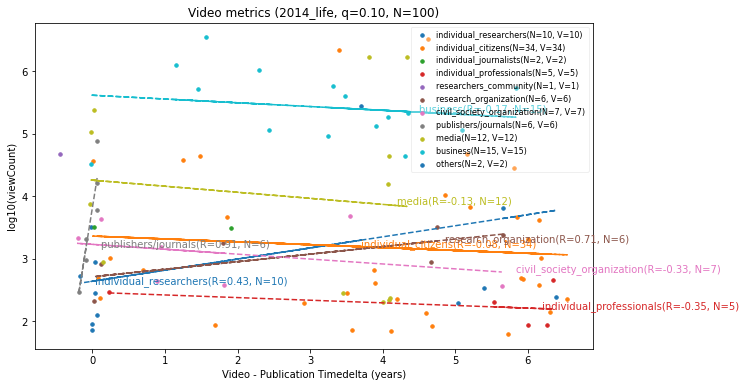

In [10]:
plot_timedelta_metrics(targets="2014_life", q=0.1, metric="viewCount", label_by="user_type", scale_by_sub=False, regression=True)

Quantile 0.10
2014_comp: 20.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>20']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>20);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`;
[+]Processing 1 of 132 videos
[+]Processing 2 of 132 videos
[+]Processing 3 of 132 videos
[+]Processing 4 of 132 videos
[+]Processing 5 of 132 videos
[+]Processing 6 of 132 videos
[+]Processing 7 of 132 videos
[+]Processing 8 of 132 videos
[+]Processing 9 of 132 videos
[+]Pro

	Command set: SELECT channelId FROM `channels`
	Current list_where_clauses: ["`user_type`='business'"]
	sql: SELECT channelId FROM `channels` WHERE (`user_type`='business');
	Current where: ('channelId', ['UCP7jMXSY2xbc3KCAE0MHQ-A', 'UCJINtWke3-FMz2WuEltWDVQ', 'UC1dlmB1lup9RwFQBSGnhA-g', 'UCkDJOtcty2tgJt5HznOfOJQ', 'UC60R_m2CQS2o1i3GQ3jpDxg', 'UCRTV5p4JsXV3YTdYpTJECRA', 'UCkw4JCwteGrDHIsyIIKo4tQ', 'UCjeevuqcVsC5o-Kgc6QaCVQ', 'UC8-ttzWLgXZOGuhUyrPlUuA', 'UCdeSxuESqLOxuuwXNnqqbrA', 'UCPzx2mFggm_Fv5BJYUJOpnA', 'UCrydv6TcnK6cxtxoyXb-BDA', 'UCrMePiHCWG4Vwqv3t7W9EFg', 'UCC552Sd-3nyi_tk2BudLUzA', 'UCeiYXex_fwgYDonaTcSIk6w', 'UCZYTClx2T1of7BRZ86-8fow', 'UCaHBABJFMRAtnKhQp2Cu5BQ', 'UCZxdc2K-ADS0XydBRDm2F7w', 'UCBa659QWEk1AI4Tg--mrJ2A', 'UCB0zinWfy-dS_NqcOINYo3A', 'UC7AiqN6-H0HxVcyW4qjhtnw', 'UCfxwT02Bu5R7l21uMAu8H1w'], 'in')
	Current list_where_clauses: ["channelId IN ('UCP7jMXSY2xbc3KCAE0MHQ-A', 'UCJINtWke3-FMz2WuEltWDVQ', 'UC1dlmB1lup9RwFQBSGnhA-g', 'UCkDJOtcty2tgJt5HznOfOJQ', 'UC60R_m2CQS2o1

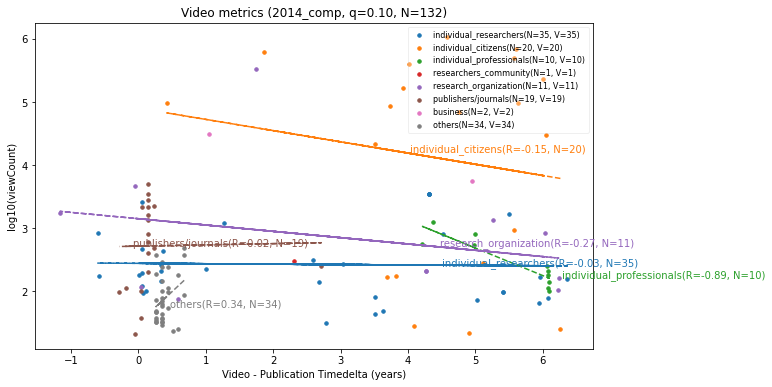

In [11]:
plot_timedelta_metrics(targets="2014_comp", q=0.1, metric="viewCount", label_by="user_type", scale_by_sub=False, regression=True)

timedelta 不要かな。わかりにくくなっている。
１グラフ１メッセージ

Quantile 0.10
2014_life: 61.1	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>61']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life` WHERE (`viewCount`>61);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 100 videos
[+]Processing 2 of 100 videos
[+]Processing 3 of 100 videos
[+]Processing 4 of 100 videos
[+]Processing 5 of 100 videos
[+]Processing 6 of 100 vi

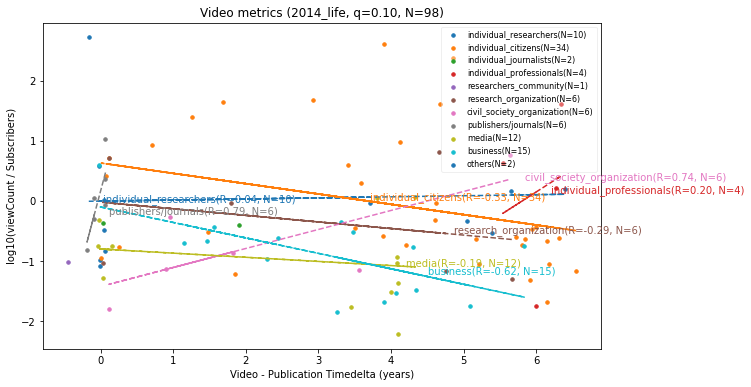

In [5]:
plot_timedelta_metrics(targets="2014_life", q=0.1, metric="viewCount", label_by="user_type", scale_by_sub=True, regression=True)

Quantile 0.10
2014_comp: 20.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>20']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>20);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 132 videos
[+]Processing 2 of 132 videos
[+]Processing 3 of 132 videos
[+]Processing 4 of 132 videos
[+]Processing 5 of 132 videos
[+]Processing 6 of 132 vi

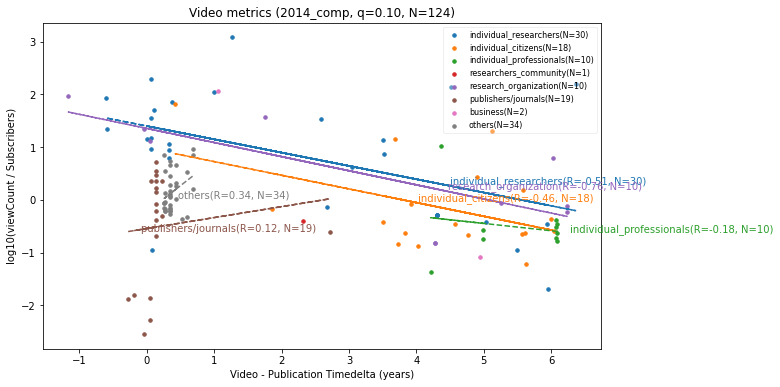

In [6]:
plot_timedelta_metrics(targets="2014_comp", q=0.1, metric="viewCount", label_by="user_type", scale_by_sub=True, regression=True)

2014 by user_type

2014_compではResearch organizationsが個人より高い

2014_lifeでは個人がresearch organizationsより高い傾向

→研究機関からのYT投稿は、数学・コンピューター科学分野が、生命・惑星科学より注目される傾向

Quantile 0.10
2014_life: 61.1	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>61']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life` WHERE (`viewCount`>61);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`;
[+]Processing 1 of 100 videos
[+]Processing 2 of 100 videos
[+]Processing 3 of 100 videos
[+]Processing 4 of 100 videos
[+]Processing 5 of 100 videos
[+]Processing 6 of 100 videos
[+]Processing 7 of 100 videos
[+]Processing 8 of 100 videos
[+]Processing 9 of 100 videos
[+]Pro

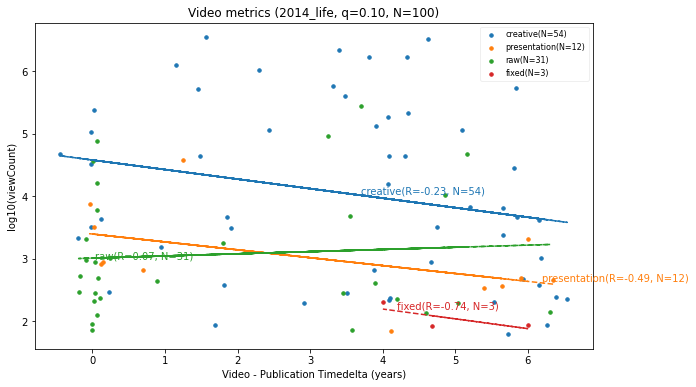

In [7]:
plot_timedelta_metrics(targets="2014_life", q=0.1, metric="viewCount", label_by="video_visual", scale_by_sub=False, regression=True)

Quantile 0.10
2014_comp: 20.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>20']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>20);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`;
[+]Processing 1 of 132 videos
[+]Processing 2 of 132 videos
[+]Processing 3 of 132 videos
[+]Processing 4 of 132 videos
[+]Processing 5 of 132 videos
[+]Processing 6 of 132 videos
[+]Processing 7 of 132 videos
[+]Processing 8 of 132 videos
[+]Processing 9 of 132 videos
[+]Pro

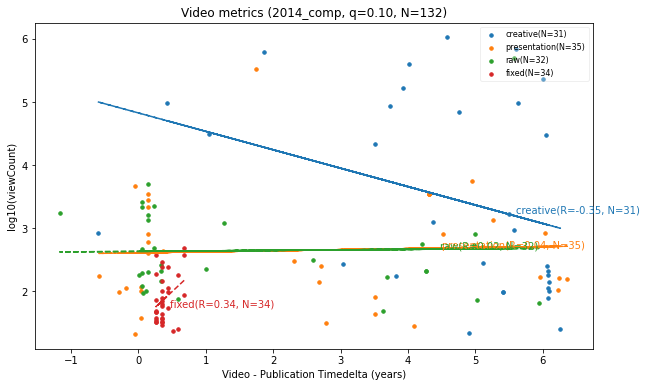

In [8]:
plot_timedelta_metrics(targets="2014_comp", q=0.1, metric="viewCount", label_by="video_visual", scale_by_sub=False, regression=True)

Quantile 0.10
2014_life: 61.1	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life`
	Current list_where_clauses: ['`viewCount`>61']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_life` WHERE (`viewCount`>61);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 100 videos
[+]Processing 2 of 100 videos
[+]Processing 3 of 100 videos
[+]Processing 4 of 100 videos
[+]Processing 5 of 100 videos
[+]Processing 6 of 100 vi

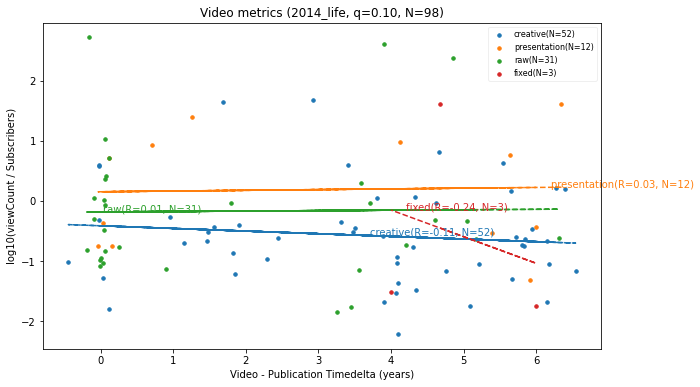

In [9]:
plot_timedelta_metrics(targets="2014_life", q=0.1, metric="viewCount", label_by="video_visual", scale_by_sub=True, regression=True)

Quantile 0.10
2014_comp: 20.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp`
	Current list_where_clauses: ['`viewCount`>20']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2014_comp` WHERE (`viewCount`>20);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 132 videos
[+]Processing 2 of 132 videos
[+]Processing 3 of 132 videos
[+]Processing 4 of 132 videos
[+]Processing 5 of 132 videos
[+]Processing 6 of 132 vi

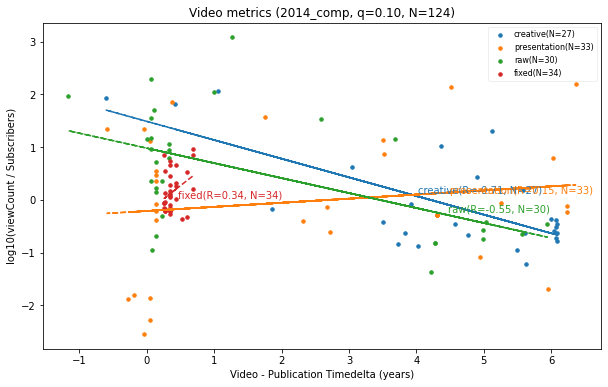

In [10]:
plot_timedelta_metrics(targets="2014_comp", q=0.1, metric="viewCount", label_by="video_visual", scale_by_sub=True, regression=True)

2019 label by content

Quantile 0.10
2019_life: 53.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2019_life`
	Current list_where_clauses: ['`viewCount`>53']
	Current list_where_clauses: ['`viewCount`>53', 'idx IN (2, 3, 6, 10, 12, 17, 18, 38, 43, 50, 55, 56, 59, 67, 72, 73, 78, 86, 88, 90, 93, 94, 101, 108, 109, 110, 113, 116, 120, 122, 124, 128, 129, 130, 139, 140, 142, 145, 150, 153, 158, 159, 161, 163, 165, 166, 171, 175, 178, 181, 184, 190, 195, 199, 208, 209, 214, 217, 222, 223, 230, 232, 233, 238, 246, 247, 254, 256, 258, 264, 267, 270, 271, 275, 277, 281, 284, 286, 291, 292, 297, 298, 299, 300, 303, 305, 310, 311, 314, 316, 317, 318, 324, 326, 327, 330, 333, 334, 340, 343)']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`,

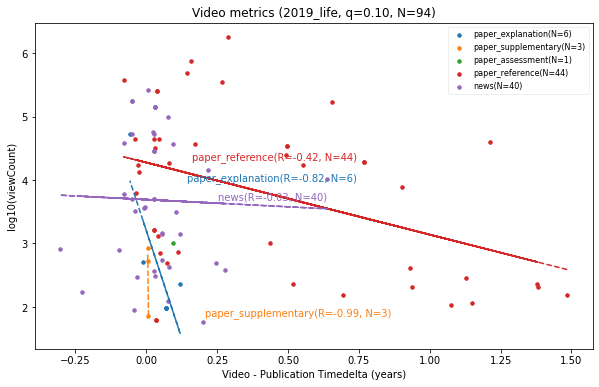

In [12]:
tup_target_idx = (2, 3, 6, 10, 12, 17, 18, 38, 43, 50, 55, 56, 59, 67, 72, 73, 78, 86, 88, 90, 93, 94, 101, 108, 109, 110, 113, 116, 120, 122, 124, 128, 129, 130, 139, 140, 142, 145, 150, 153, 158, 159, 161, 163, 165, 166, 171, 175, 178, 181, 184, 190, 195, 199, 208, 209, 214, 217, 222, 223, 230, 232, 233, 238, 246, 247, 254, 256, 258, 264, 267, 270, 271, 275, 277, 281, 284, 286, 291, 292, 297, 298, 299, 300, 303, 305, 310, 311, 314, 316, 317, 318, 324, 326, 327, 330, 333, 334, 340, 343)
plot_timedelta_metrics(targets="2019_life", where_videos=("idx", tup_target_idx, "in"), q=0.1, metric="viewCount", label_by="content", scale_by_sub=False, regression=True)

Quantile 0.10
2019_comp: 5.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2019_comp`
	Current list_where_clauses: ['`viewCount`>5']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2019_comp` WHERE (`viewCount`>5);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`;
[+]Processing 1 of 71 videos
[+]Processing 2 of 71 videos
[+]Processing 3 of 71 videos
[+]Processing 4 of 71 videos
[+]Processing 5 of 71 videos
[+]Processing 6 of 71 videos
[+]Processing 7 of 71 videos
[+]Processing 8 of 71 videos
[+]Processing 9 of 71 videos
[+]Processing 10 o

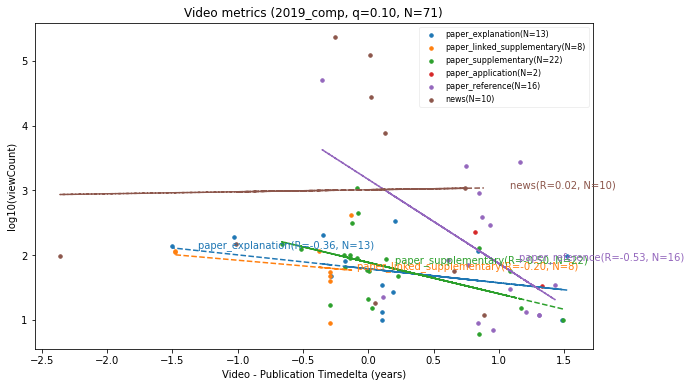

In [13]:
plot_timedelta_metrics(targets="2019_comp", q=0.1, metric="viewCount", label_by="content", scale_by_sub=False, regression=True)

Quantile 0.10
2019_life: 53.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2019_life`
	Current list_where_clauses: ['`viewCount`>53']
	Current list_where_clauses: ['`viewCount`>53', 'idx IN (2, 3, 6, 10, 12, 17, 18, 38, 43, 50, 55, 56, 59, 67, 72, 73, 78, 86, 88, 90, 93, 94, 101, 108, 109, 110, 113, 116, 120, 122, 124, 128, 129, 130, 139, 140, 142, 145, 150, 153, 158, 159, 161, 163, 165, 166, 171, 175, 178, 181, 184, 190, 195, 199, 208, 209, 214, 217, 222, 223, 230, 232, 233, 238, 246, 247, 254, 256, 258, 264, 267, 270, 271, 275, 277, 281, 284, 286, 291, 292, 297, 298, 299, 300, 303, 305, 310, 311, 314, 316, 317, 318, 324, 326, 327, 330, 333, 334, 340, 343)']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`,

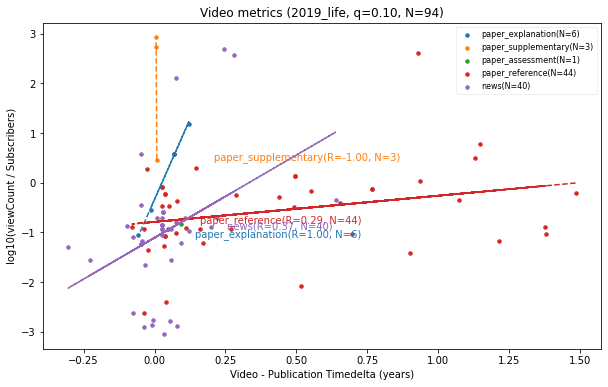

In [14]:
tup_target_idx = (2, 3, 6, 10, 12, 17, 18, 38, 43, 50, 55, 56, 59, 67, 72, 73, 78, 86, 88, 90, 93, 94, 101, 108, 109, 110, 113, 116, 120, 122, 124, 128, 129, 130, 139, 140, 142, 145, 150, 153, 158, 159, 161, 163, 165, 166, 171, 175, 178, 181, 184, 190, 195, 199, 208, 209, 214, 217, 222, 223, 230, 232, 233, 238, 246, 247, 254, 256, 258, 264, 267, 270, 271, 275, 277, 281, 284, 286, 291, 292, 297, 298, 299, 300, 303, 305, 310, 311, 314, 316, 317, 318, 324, 326, 327, 330, 333, 334, 340, 343)
plot_timedelta_metrics(targets="2019_life", where_videos=("idx", tup_target_idx, "in"), q=0.1, metric="viewCount", label_by="content", scale_by_sub=True, regression=True)

Quantile 0.10
2019_comp: 5.0	
	Command set: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2019_comp`
	Current list_where_clauses: ['`viewCount`>5']
	sql: SELECT `idx`, `idx_paper`, `content`, `video_visual`, `publishedAt`, `duration`, `channelId`, `viewCount`, `likeCount`, `dislikeCount`, `commentCount`, `favoriteCount`, `liveStreaming` FROM `scopus_videos_2019_comp` WHERE (`viewCount`>5);
	Command set: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels`
	Current list_where_clauses: ['`subscriberCount` IS NOT NULL']
	sql: SELECT `idx`, `channelId`, `subscriberCount`, `user_type` FROM `channels` WHERE (`subscriberCount` IS NOT NULL);
[+]Processing 1 of 71 videos
[+]Processing 2 of 71 videos
[+]Processing 3 of 71 videos
[+]Processing 4 of 71 videos
[+]Processing 5 of 71 videos
[+]Processing 6 of 71 videos
[+]P

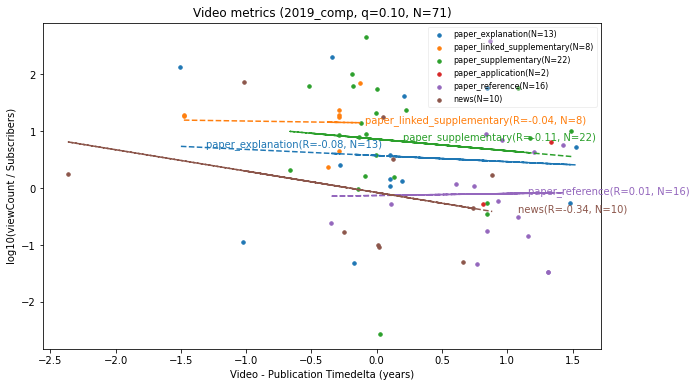

In [15]:
plot_timedelta_metrics(targets="2019_comp", q=0.1, metric="viewCount", label_by="content", scale_by_sub=True, regression=True)